In [149]:
import numpy as np
np.random.seed(1) # for reproducibility

import keras.backend as K
import tensorflow as tf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import pickle
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import optimizers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [150]:
hsbc = yf.download('AAPL', start='2000-01-01', end='2024-05-31')
# hsbc = hsbc.drop(['Adj Close'], axis=1)
#remove row with volume = 0
# hsbc = hsbc.drop(hsbc[hsbc.Volume==0].index)
print(hsbc.head())

[*********************100%***********************]  1 of 1 completed

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2000-01-03 00:00:00+00:00  0.844004  0.999442  1.004464  0.907924  0.936384   
2000-01-04 00:00:00+00:00  0.772846  0.915179  0.987723  0.903460  0.966518   
2000-01-05 00:00:00+00:00  0.784155  0.928571  0.987165  0.919643  0.926339   
2000-01-06 00:00:00+00:00  0.716296  0.848214  0.955357  0.848214  0.947545   
2000-01-07 00:00:00+00:00  0.750226  0.888393  0.901786  0.852679  0.861607   

Price                         Volume  
Ticker                          AAPL  
Date                                  
2000-01-03 00:00:00+00:00  535796800  
2000-01-04 00:00:00+00:00  512377600  
2000-01-05 00:00:00+00:00  778321600  
2000-01-06 00:00:00+00:00  767972800  
2000-01-07 00:00:00+00:00  460734400  


In [151]:
def create_data(dataset,window_size = 10):
    # df = dataset.to_numpy()
    df = dataset.copy()
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [a for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
        
    return np.array(X),np.array(y)

In [152]:
hsbc.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
count,6141.000000,6141.000000,6141.000000,6141.000000,6141.000000,6.141000e+03
mean,36.881946,38.303664,38.689136,37.886597,38.280132,3.939011e+08
std,53.619303,53.940999,54.472284,53.363185,53.898321,3.847900e+08
min,0.197849,0.234286,0.235536,0.227143,0.231964,2.404830e+07
25%,1.917864,2.271071,2.314643,2.245000,2.283571,1.239340e+08
50%,13.133579,15.298214,15.436429,15.155357,15.278571,2.754264e+08
75%,40.971661,43.200001,43.610001,42.912498,43.207500,5.287184e+08
max,197.361084,198.110001,199.619995,197.000000,198.020004,7.421641e+09


In [153]:
data = hsbc[[('Adj Close','AAPL')]]

In [154]:
data

Price,Adj Close
Ticker,AAPL
Date,
2000-01-03 00:00:00+00:00,0.844004
2000-01-04 00:00:00+00:00,0.772846
2000-01-05 00:00:00+00:00,0.784155
2000-01-06 00:00:00+00:00,0.716296
2000-01-07 00:00:00+00:00,0.750226
...,...
2024-05-23 00:00:00+00:00,186.663940
2024-05-24 00:00:00+00:00,189.760345


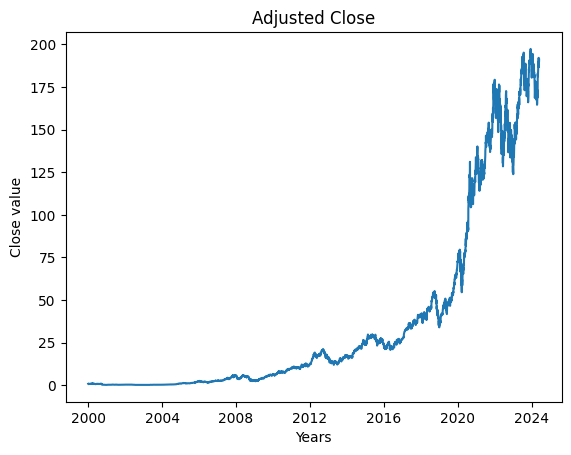

In [155]:
plt.title('Adjusted Close')
plt.xlabel('Years')
plt.ylabel('Close value')
plt.plot(data)

In [156]:
scaler = MinMaxScaler()
hsbc_scaled = scaler.fit_transform(data)

In [157]:
hsbc_scaled

array([[0.00327726],
       [0.00291635],
       [0.00297371],
       ...,
       [0.96150028],
       [0.96302002],
       [0.96808608]])

In [158]:
WINDOW_SIZE = 10

X,y = create_data(hsbc_scaled,WINDOW_SIZE)

In [159]:
X.shape

(6131, 10, 1)

In [160]:
y.shape

(6131, 1)

In [161]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [162]:
X_train.shape

(4904, 10, 1)

In [163]:
X_test.shape

(1227, 10, 1)

In [166]:
model_mse = Sequential()
model_mse.add(InputLayer(shape = (10,1)))
model_mse.add(LSTM(64))
model_mse.add(Dense(8,'relu'))
model_mse.add(Dense(1,'linear'))

# model_mse.summary()
model_mse.compile(loss='mse',optimizer=Adam(learning_rate=0.0001),metrics = [RootMeanSquaredError()])
# history_mse = model_mse.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,callbacks=[cp])
history_mse = model_mse.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0726 - root_mean_squared_error: 0.2656 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - root_mean_squared_error: 0.0587 - val_loss: 2.7245e-04 - val_root_mean_squared_error: 0.0165
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1428e-04 - root_mean_squared_error: 0.0146 - val_loss: 2.0489e-04 - val_root_mean_squared_error: 0.0143
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9180e-04 - root_mean_squared_error: 0.0138 - val_loss: 1.7661e-04 - val_root_mean_squared_error: 0.0133
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6232e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.6263e-04 - val_root_mean_squared_error: 0.0128
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.4938e-04 - root_mean_squared_error: 0.0122 - val_loss: 1.5552e-04 - val_root_mean_squared_error: 0.0125
Epoch 7/10
15

In [167]:
model_mae = Sequential()
model_mae.add(InputLayer(shape = (10,1)))
model_mae.add(LSTM(64))
model_mae.add(Dense(8,'relu'))
model_mae.add(Dense(1,'linear'))

# model_mae.summary()
# cp = model_maeCheckpoint('output/best_model.weights.h5',save_weights_only=False)
# cp = model_maeCheckpoint('output/best_model.keras',save_weights_only=False)
model_mae.compile(loss='mse',optimizer=Adam(learning_rate=0.0001),metrics = [RootMeanSquaredError()])
history_mae = model_mae.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0348 - root_mean_squared_error: 0.1805 - val_loss: 4.7105e-04 - val_root_mean_squared_error: 0.0217
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4159e-04 - root_mean_squared_error: 0.0154 - val_loss: 1.7215e-04 - val_root_mean_squared_error: 0.0131
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5287e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6185e-04 - val_root_mean_squared_error: 0.0127
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4465e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.5466e-04 - val_root_mean_squared_error: 0.0124
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2673e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.4424e-04 - val_root_mean_squared_error: 0.0120
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1832e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.3707e-04 - val_root_mean_squared_error: 0.0117
Epoch 7/

In [168]:
train_results

,Train_Prediction_MSE,Train_Prediction_MAE,Train_Prediction_Custom,Actuals
0,0.081306,0.079889,0.077511,0.081192
1,0.068168,0.067387,0.064733,0.070578
2,0.135363,0.133748,0.132474,0.135978
3,0.722361,0.714212,0.710188,0.720098
4,0.183456,0.180519,0.179877,0.180600
...,...,...,...,...
4899,0.123009,0.121273,0.119872,0.119782
4900,0.629953,0.631868,0.619069,0.598141
4901,0.598931,0.593580,0.583772,0.569195
4902,0.646140,0.645103,0.634176,0.657975


In [169]:
import tensorflow as tf
import keras.backend as K
def custom_loss(y_true, y_pred):
    # Extract "next day's price" and "today's price"
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    # Calculate the up/down movement (direction) for both y_true and y_pred
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
    
    # Compare movements: if the difference is positive, it's an "UP" (1), else "DOWN" (0)
    y_true_move = tf.cast(tf.greater_equal(y_true_diff, 0), tf.float32)
    y_pred_move = tf.cast(tf.greater_equal(y_pred_diff, 0), tf.float32)
    
    # Find positions where predicted direction does not match the true direction
    direction_mismatch = tf.not_equal(y_true_move, y_pred_move)
    
    # Apply a penalty for mismatches, use tf.where to conditionally apply penalty
    penalty_factor = tf.reduce_mean(tf.abs(y_true_diff)) 
    penalty = tf.where(direction_mismatch, 
                       (tf.abs(y_true_diff - y_pred_diff) * penalty_factor), 
                       tf.zeros_like(y_true_diff))   
    # Mean squared error loss
    # mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    
    # Combine the MSE loss with the directional penalty
    custom_loss = mse_loss + penalty
    
    return custom_loss


In [170]:
model_custom = Sequential()
model_custom.add(InputLayer(shape = (10,1)))
model_custom.add(LSTM(64))
model_custom.add(Dense(8,'relu'))
model_custom.add(Dense(1,'linear'))

model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.0001),metrics = [RootMeanSquaredError()])
# model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.0001),metrics = ['accuracy'])

history_custom = model_custom.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0598 - root_mean_squared_error: 0.2406 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0601
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0387 - val_loss: 2.5237e-04 - val_root_mean_squared_error: 0.0146
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9743e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.1141e-04 - val_root_mean_squared_error: 0.0131
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0198e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.9726e-04 - val_root_mean_squared_error: 0.0126
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5732e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.8454e-04 - val_root_mean_squared_error: 0.0120
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9448e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.8190e-04 - val_root_mean_squared_error: 0.0119
Epoch 7/10
154/1

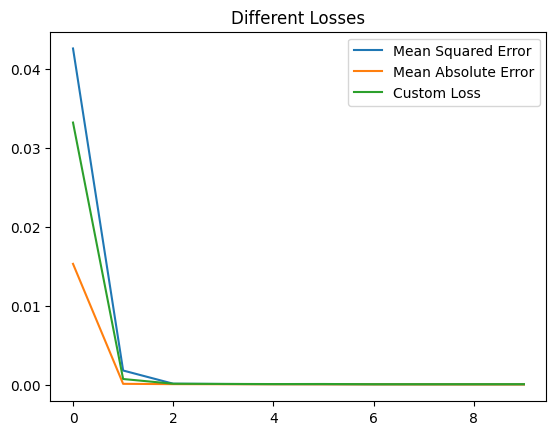

In [186]:
plt.plot(history_mse.history['loss'],label = 'Mean Squared Error')
plt.plot(history_mae.history['loss'],label = 'Mean Absolute Error')
plt.plot(history_custom.history['loss'],label = 'Custom Loss')
plt.title('Different Losses')
plt.legend()
plt.show()

In [172]:
train_predictions_mse = model_mse.predict(X_train).flatten()
train_predictions_mae = model_mae.predict(X_train).flatten()
train_predictions_custom = model_custom.predict(X_train).flatten()

train_predictions_mse_val = model_mse.predict(X_test).flatten()
train_predictions_mae_val = model_mae.predict(X_test).flatten()
train_predictions_custom_val = model_custom.predict(X_test).flatten()


154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


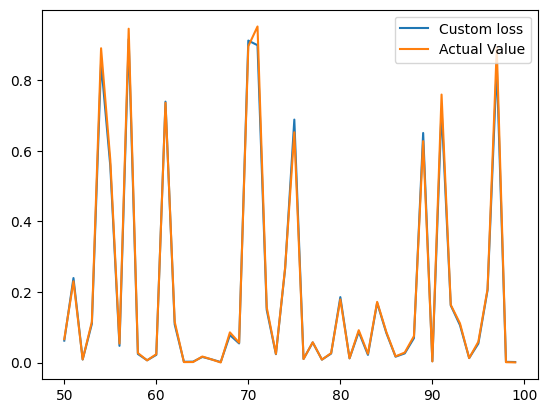

In [173]:
# plt.plot(train_results['Train_Prediction_MSE'][50:100],label = "MSE")
# plt.plot(train_results['Train_Prediction_MAE'][50:100],label = "MAE")
plt.plot(train_results['Train_Prediction_Custom'][50:100],label = "Custom loss")
plt.plot(train_results['Actuals'][50:100],label = "Actual Value")
plt.legend(loc='upper right')
plt.show()

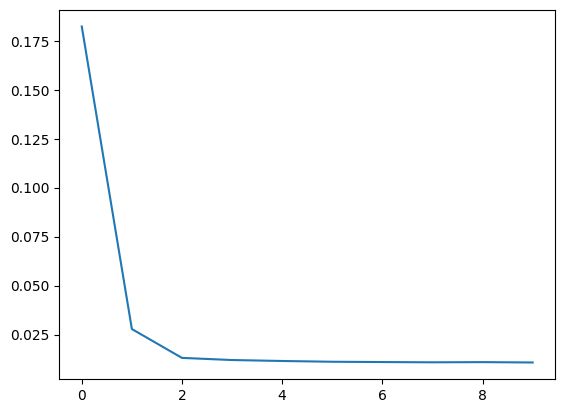

In [176]:
plt.plot(history_custom.history['root_mean_squared_error'])
plt.show()

In [177]:
train_predictions_custom_val = model_custom.predict(X_test).flatten()
train_predictions = model_mse.predict(X_test).flatten()

 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


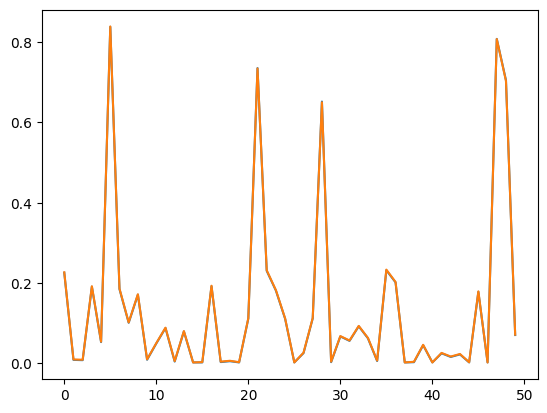

In [178]:
plt.plot(train_predictions_custom_val[50:100])
plt.plot(train_predictions[50:100])
plt.show()

In [182]:
from sklearn.metrics import r2_score,mean_absolute_error

In [183]:
print(r2_score(train_predictions_custom_val,train_predictions))

0.9999858736991882


In [184]:
print(mean_absolute_error(train_predictions_custom_val,train_predictions))

0.0009171128
